# Presentation IMA205 Project Cardiac Disease Classification
This notebook presents the work done in an easy and clear way. The idea is that every step developed of the full stack can be presented and explained here.

In [1]:
# Importing the classes
import pandas as pd
import torch
import random
import torch.nn.functional as F
from densenet.densenet import DenseNet
from roi import ROI
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from densnet_trainer import DenseNetTrainer
from niidataloader import NiftiDataset
from feature_extractor import FeatureExtractor
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Introduction


The whole project has as north the paper: PONER EL NOMBRE DEL PAPER.
This papaer has multiple steps on its pipeline: First extract the Region Of Interest (ROI), this is the subimage where the left ventricle cavity, right vecntricle cavity and myocardium are. The output of the ROI step is a 128x128 image that will be later be segmented. The following code shows how the ROI extractor works.

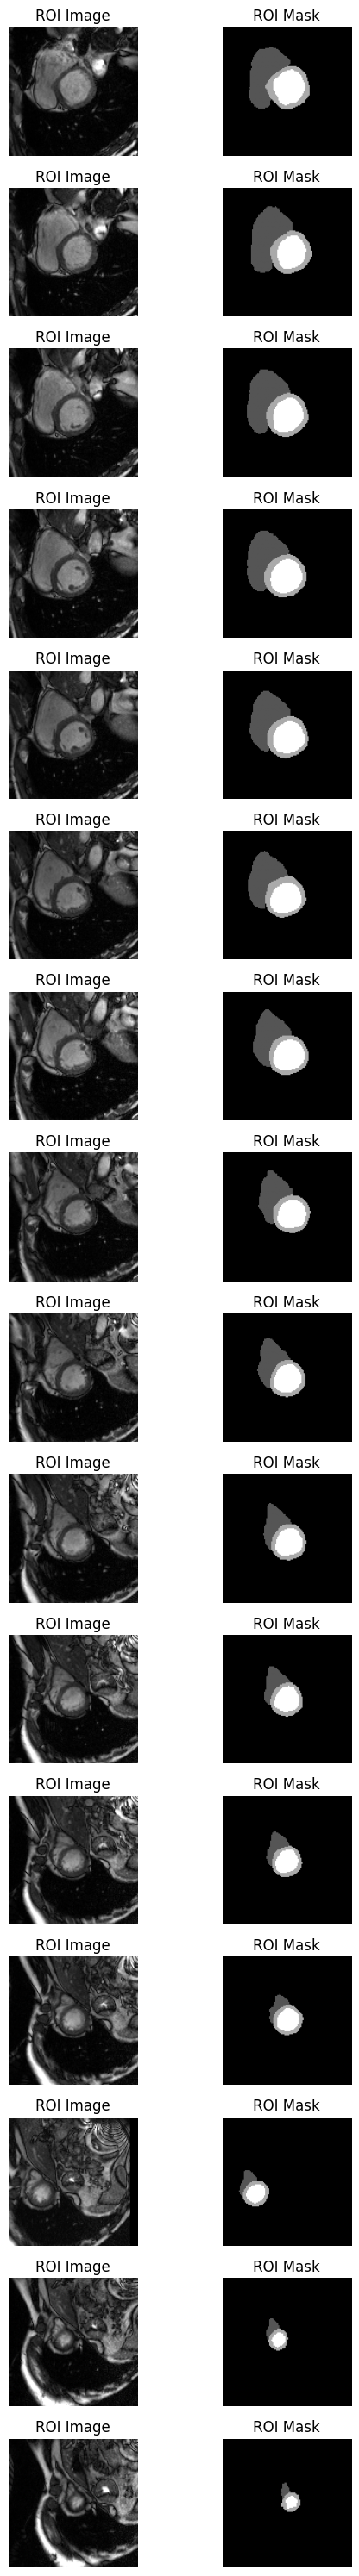

In [2]:
# plot the ROI images
# Load the dataset
roi_extractor = ROI('data/Train')
random.seed(42)
random_int = random.randint(0,100)
roi_image, roi_mask = roi_extractor.get_roi(random_int)
# Create a figure for everty slize in the image
fig, axs = plt.subplots(roi_image.shape[0], 2, figsize=(6, 30))
# Display the image and mask
for index in range(roi_image.shape[0]):
    axs[index, 0].imshow(roi_image[index], cmap='gray')
    axs[index, 1].imshow(roi_mask[index], cmap='gray')
    axs[index, 0].set_title('ROI Image')
    axs[index, 1].set_title('ROI Mask')
    axs[index, 0].axis('off')
    axs[index, 1].axis('off')
plt.tight_layout()
plt.show()



The NiftiDataset is the dataset that I made for this project, it loads the .nii images and returns a (4,220,220,num_slices) tensor. The first 4 correspond to the different images that we have from the same heart, the first one correspond to the end of diastolic phase, the second one to its mask (ground truth), the third one to the end of systolic phase and the last one to its mask.
This dataset have the option to augment the data (with the specifications provided in the paper) and output the ROI for each image (can be augmented as well). All of this was done in order to simplify the training of the densenet.

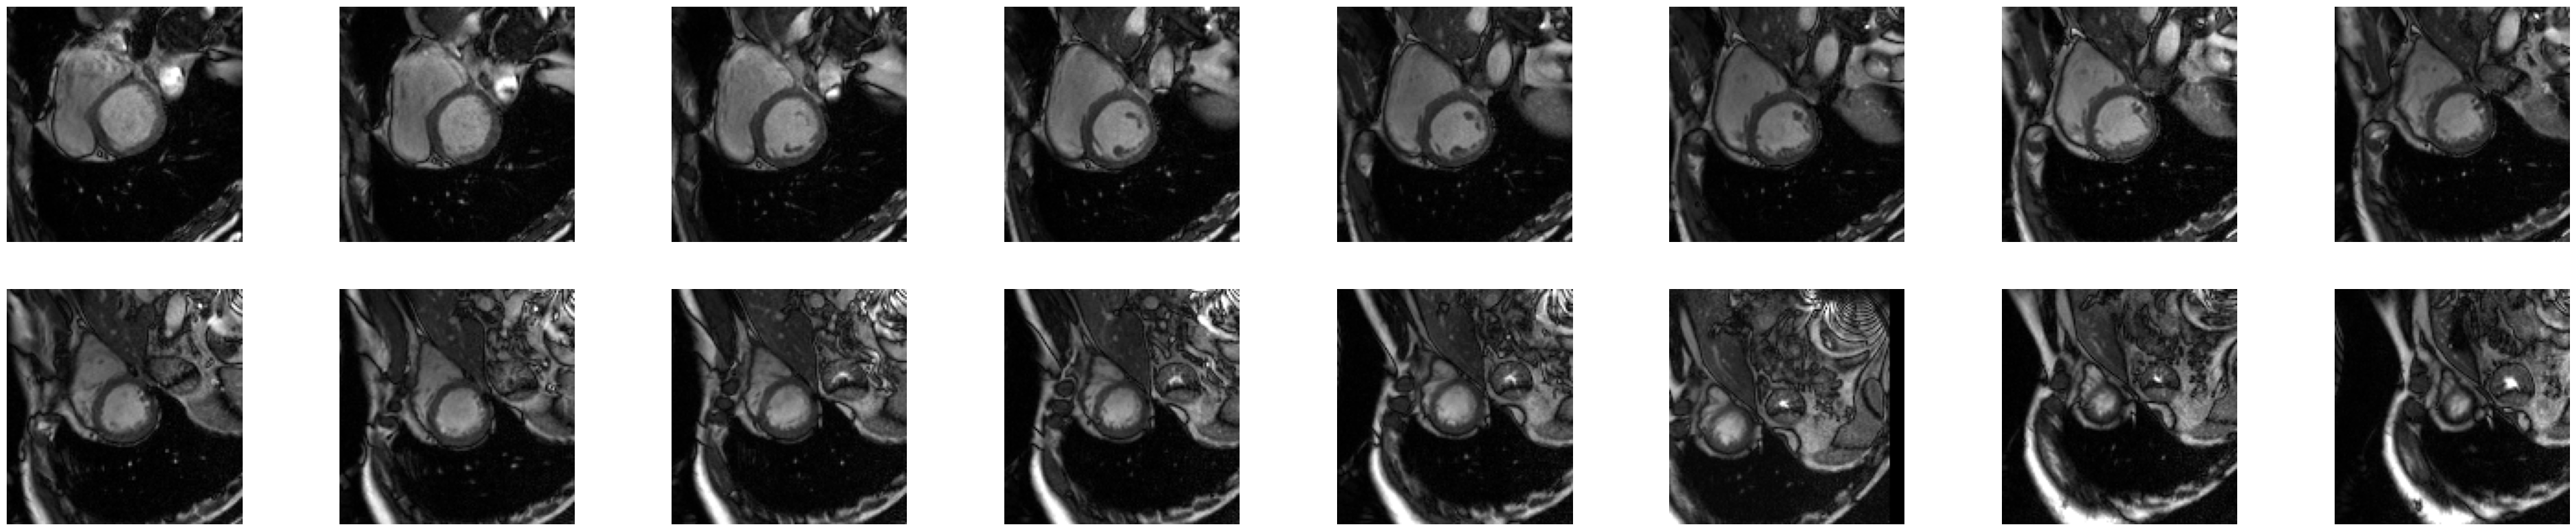

In [3]:
data_path = "./data/Train"
niftiidataset = NiftiDataset(image_path = data_path, roi=True, augment=False)
diastolic_loaded_image = niftiidataset[random_int][0]
# print(diastolic_loaded_image.shape[-1])
amount_of_slices_over_2=int(roi_image.shape[0]/2)
# print(amount_of_slices_over_2)
fig, axs = plt.subplots(2,amount_of_slices_over_2, figsize=(50, 10))
for img_idx in range(diastolic_loaded_image.shape[-1]):
    img = diastolic_loaded_image[:,:,img_idx]
    img_idx_2 = int(img_idx%amount_of_slices_over_2)
    am_img=int(img_idx/amount_of_slices_over_2)
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].axis('off')
    axs[am_img,img_idx_2].axis('off')
    # print(img_idx_2, am_img)


After having the image ROI image we will used the densenet described in the paper to segment it, and extract from there the left cavity, right cavity, miocardium and background.
There are two ways of doing this, you can either train the model from the begining or you can use my already trained model, the one that was sent with this work in a .pth file.

In [4]:
# IF set to true will train the model again. The training took me approximately two hours.
Train_model = False
device = torch.device("cuda")
work_dir = "/home/onyxia/work/project/CardiacPathologyPrediction/"

if Train_model:
    model = DenseNet()
    trainer = DenseNetTrainer(data_path)
    # The trainer configuration is like the one in the article
    trainer = DenseNetTrainer(data_path, epochs=200, alpha=0.25, train_fraction=0.8, check_val_every=10)
    trainer.train(model=model)
    model.eval()
else:
    # Load the Model
    model = DenseNet()
    # Load the model weights
    model.load_state_dict(torch.load(work_dir + 'model_weights_best_dice_val0.8000605702400208.pth')["model_state_dict"])
    model.to(device)
    model.eval()

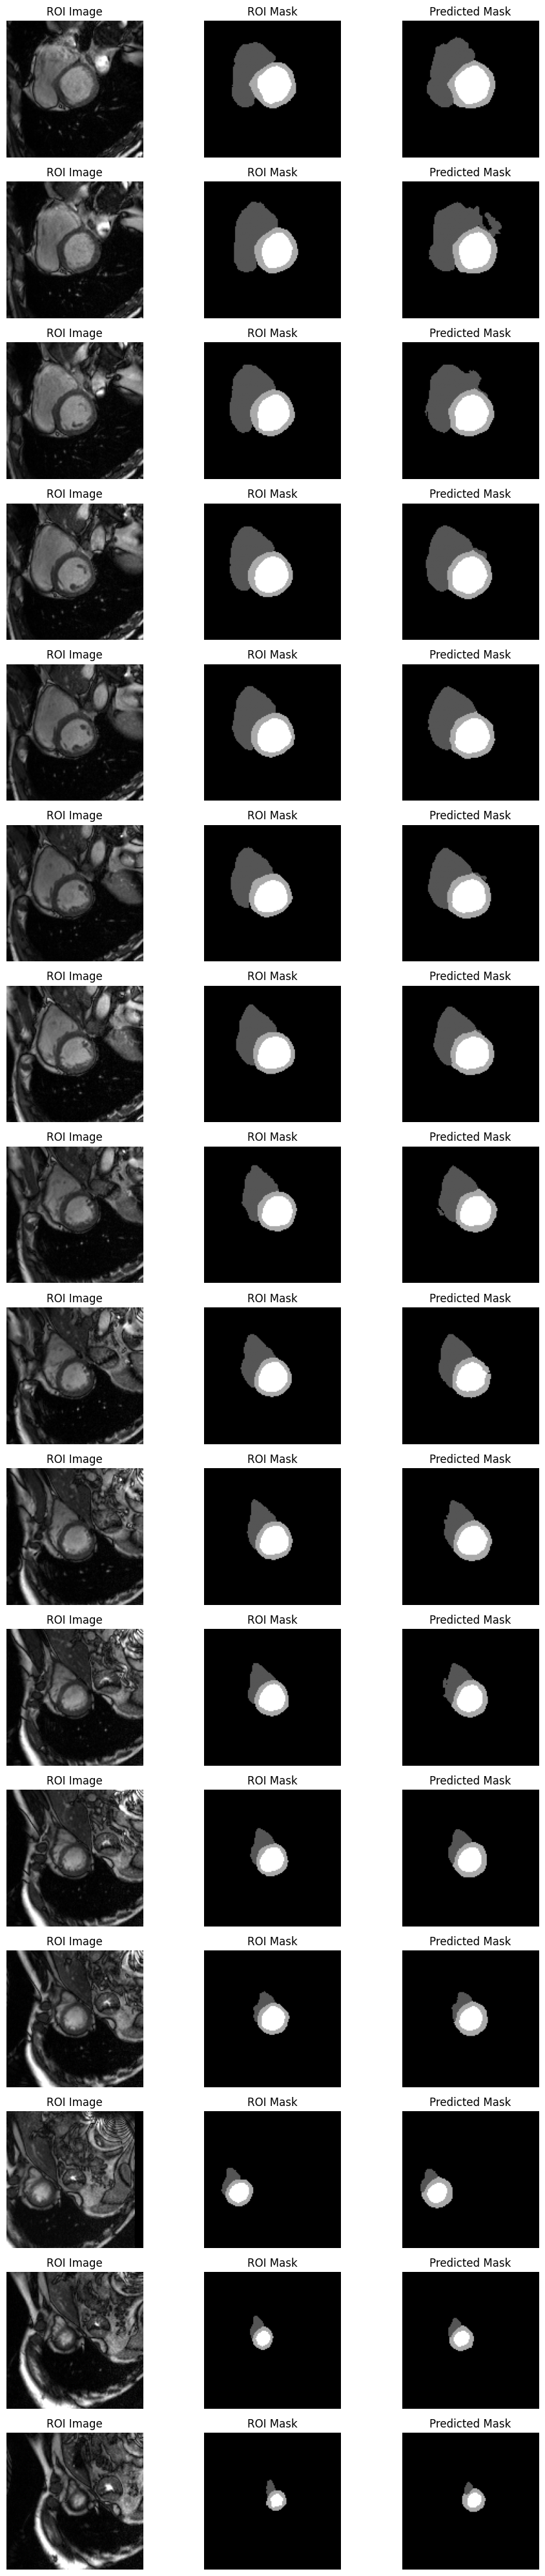

In [5]:
fig, axs = plt.subplots(roi_image.shape[0], 3, figsize=(10, 40))
# Display the image and mask
diastolic_loaded_image_mask = niftiidataset[random_int][1]
img = diastolic_loaded_image.to(torch.float32).permute(2,0,1)
img = img.unsqueeze(1)
img = img.to(device)
predicted_mask = model(img).squeeze(0).detach().cpu().numpy()
img = img.squeeze(1).detach().cpu().numpy()
predicted_mask = (predicted_mask>0.5)
predicted_mask[:,1] = model.get_largest_component(predicted_mask[:,1])
predicted_mask[:,2] = model.get_largest_component(predicted_mask[:,2])
predicted_mask[:,3] = model.get_largest_component(predicted_mask[:,3])

pred_mask = 0*predicted_mask[:,0] + 1*predicted_mask[:,1] + 2*predicted_mask[:,2] + 3*predicted_mask[:,3]
pred_mask = pred_mask/3
for img_idx in range(pred_mask.shape[0]):
    mask = diastolic_loaded_image_mask[:,:,img_idx]
    axs[img_idx, 0].imshow(img[img_idx], cmap='gray')
    axs[img_idx, 1].imshow(mask, cmap='gray')
    axs[img_idx, 2].imshow(pred_mask[img_idx], cmap='gray')
    axs[img_idx, 0].set_title('ROI Image')
    axs[img_idx, 1].set_title('ROI Mask')
    axs[img_idx, 2].set_title('Predicted Mask')
    axs[img_idx, 0].axis('off')
    axs[img_idx, 1].axis('off')
    axs[img_idx, 2].axis('off')
plt.tight_layout()
plt.show()

Now we will use the feature extraction model to extract the features from the 3D the features to use were extracted from the paper: PONER LOS PAPERS DE LAS FEATURES. A random tree is going to be trained after the extraction of the feaures.

## Classification

This subsection is going to be divided into three independent subsections:
- First a classification done only using the masks given.
- Then one using the segmentation model only when there is no mask given in the Test set.
- Finally one using only the outputs of the segmentation model.

### Masks Only

In [6]:
# df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTrain.csv')  # replace with your actual file path
df = pd.read_csv(work_dir + 'data/metaDataTrain.csv') 
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
nifti_train = NiftiDataset(image_path = work_dir + 'data/Train', roi=False, augment=False)

dataloader = DataLoader(nifti_train, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor = FeatureExtractor()
features_tensors = []
for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    predicted_diastole = F.one_hot((img[0,1,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    predicted_systole = F.one_hot((img[0,3,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    # print(predicted_systole.shape)
    # predicted_systole = predicted_systole(0.5)
    # predicted_systole = (predicted_systole > 0.5).astype(int)
    # predicted_diastole = (predicted_diastole > 0.5).astype(int)
    # print(predicted_systole.shape)

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        (predicted_systole[:,0]).unsqueeze(0),
        (predicted_systole[:,3]).unsqueeze(0),
        (predicted_systole[:,1]).unsqueeze(0),
        (predicted_systole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        (predicted_diastole[:,0]).unsqueeze(0),
        (predicted_diastole[:,3]).unsqueeze(0),
        (predicted_diastole[:,1]).unsqueeze(0),
        (predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_train.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )

    # plt.imshow(predicted_diastole_tensor[0,1], cmap='grey')
    # print("The feature tensor is: ", features_tensor)
    # print("The actual disease is: ", gt_disease[idx])
    features_tensors.append(features_tensor)

    # if idx==50:
    #     break
gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]


Creating the dataset: 100it [00:06, 16.46it/s]


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# features_tensors = np.array(features_tensors)
# gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]<1]
feat_train, feat_test, label_train, label_test = train_test_split(
    features_tensors, 
    gt_disease, 
    test_size=0.2, 
    stratify=gt_disease,
    random_state=42
)

# Normalize the data
normalization = MinMaxScaler()
normalization.fit(feat_train)
feat_train = normalization.transform(feat_train)
feat_test = normalization.transform(feat_test)
print(np.unique(label_test))
print(np.unique(label_train))
print(feat_train[0])

[0 1 2 3 4]
[0 1 2 3 4]
[0.24316628 0.28234212 0.29365981 0.3083473  0.13528342 0.56467994
 0.7229296  0.4727323  0.57944538 0.22698853 0.54777893 0.40119032
 0.54414604 0.5780151  0.54817111 0.70634015 0.43532004 0.52666228
 0.33096256 0.37169625 0.72292956 0.47273228 0.2492801  0.31127208
 0.47619048 0.33333333 0.36272776]


In [ ]:
print("Start")

RF=RandomForestClassifier(class_weight='balanced', random_state=42)
p_grid_RF = {
    'n_estimators': [100, 200],
    'max_depth': [3,5],  # More flexibility in tree depth
    'min_samples_split': [2,4,8,10],
    'min_samples_leaf': [5,10,15],
    'bootstrap': [True, False]
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=10, verbose=1)
grid_RF.fit(feat_train, label_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(feat_test,label_test))

Start
Fitting 10 folds for each of 96 candidates, totalling 960 fits


As we can see, the outputs of the classification step are pretty promising, however, it could be interesting to do a feature analysis to try to reduce the amount of features extracted and get a better result. To do this I will extract the features with smallest importance and trying to get a better results with this subset of features. The random forest used for this porpuse is going to be the one with the best parameters found in the previous code, this because it will be hard to compute if a grid search was used.


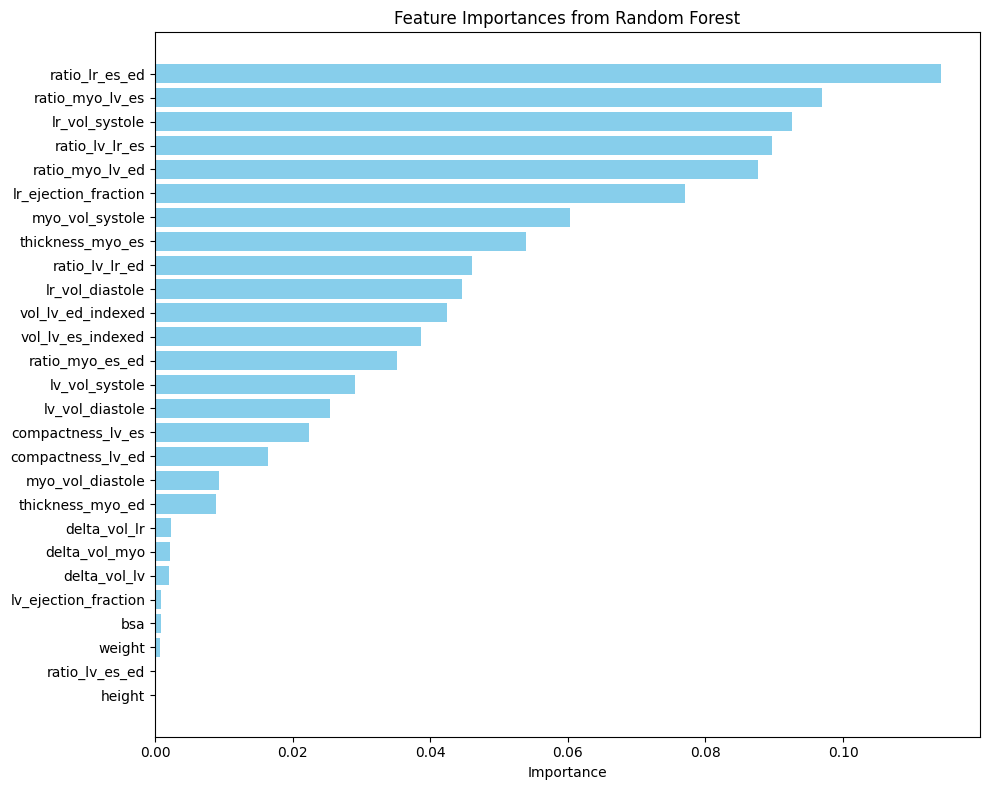

In [ ]:
RF=RandomForestClassifier(**grid_RF.best_params_, random_state=42)
RF.fit(feat_train, label_train)
# Features Importance
features = [
    "lv_vol_diastole", "lv_vol_systole", "lv_ejection_fraction",
    "lr_vol_diastole", "lr_vol_systole", "lr_ejection_fraction",
    "myo_vol_diastole", "myo_vol_systole",
    "ratio_lv_lr_ed", "ratio_lv_lr_es", "ratio_myo_lv_ed", "ratio_myo_lv_es",
    "delta_vol_lv", "delta_vol_myo", "delta_vol_lr",
    "ratio_lv_es_ed", "ratio_lr_es_ed", "ratio_myo_es_ed",
    "compactness_lv_ed", "compactness_lv_es",
    "thickness_myo_ed", "thickness_myo_es",
    "vol_lv_ed_indexed", "vol_lv_es_indexed",
    "height", "weight", "bsa"
]

importances = RF.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

As we can see there are multiple features that do not contribute almost at all to the classification.

In [ ]:
# Get the indices that would sort the importances in descending order
sorted_indices = np.argsort(RF.feature_importances_)[::-1]

# Print the sorted indices and corresponding feature names (optional)
for idx in sorted_indices:
    print(f"Index: {idx}, Feature: {features[idx]}, Importance: {RF.feature_importances_[idx]:.4f}")

Index: 0, Feature: lv_vol_diastole, Importance: 0.1877
Index: 4, Feature: lr_vol_systole, Importance: 0.1600
Index: 5, Feature: lr_ejection_fraction, Importance: 0.1250
Index: 1, Feature: lv_vol_systole, Importance: 0.1073
Index: 3, Feature: lr_vol_diastole, Importance: 0.1006
Index: 6, Feature: myo_vol_diastole, Importance: 0.0906
Index: 2, Feature: lv_ejection_fraction, Importance: 0.0882
Index: 8, Feature: ratio_lv_lr_ed, Importance: 0.0605
Index: 9, Feature: ratio_lv_lr_es, Importance: 0.0503
Index: 10, Feature: ratio_myo_lv_ed, Importance: 0.0298
Index: 7, Feature: myo_vol_systole, Importance: 0.0000


To do the experiment I now need to split the train dataset into a train and validation.

In [ ]:
ft_train, ft_val, lb_train, lb_val = train_test_split(
    feat_train, 
    label_train, 
    test_size=0.2, 
    stratify=label_train,
    random_state=42
)

# Normalize the data
normalization2 = MinMaxScaler()
normalization2.fit(ft_train)
ft_train = normalization.transform(ft_train)
ft_val = normalization.transform(ft_val)

all_features_train = ft_train
all_features_val = ft_val

In [ ]:
best_index = 0
best_accuracy = grid_RF.score(ft_val,lb_val)
for index in range(27,0,-1):
    ft_train = all_features_train[:,sorted_indices[:index]]
    ft_val = all_features_val[:,sorted_indices[:index]]
    RF=RandomForestClassifier(random_state=42,class_weight='balanced',**grid_RF.best_params_)
    RF.fit(ft_train, lb_train)
    score = RF.score(ft_val, lb_val)
    if best_accuracy <= score: # We get the best one with the smallest size
        best_index = index
        best_accuracy = score

print(f"The best index found was {best_index} with a score of {best_accuracy}")




The best index found was 23 with a score of 1.0


Now we test it in the test set from the beginning.

In [ ]:
def plot_confusion_mat(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Class names
    class_names = [
        'Healthy controls',
        'Myocardial infarction',
        'Dilated cardiomyopathy',
        'Hypertrophic cardiomyopathy',
        'Abnormal right ventricle'
    ]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
RFF = RandomForestClassifier(class_weight='balanced',**grid_RF.best_params_)
RFF.fit(feat_train[:,sorted_indices[:best_index]], label_train)

ft_test = feat_test[:,sorted_indices[:best_index]]
score_test = RFF.score(ft_test, label_test)
print(f"The new test score is: {score_test}")

The new test score is: 0.85


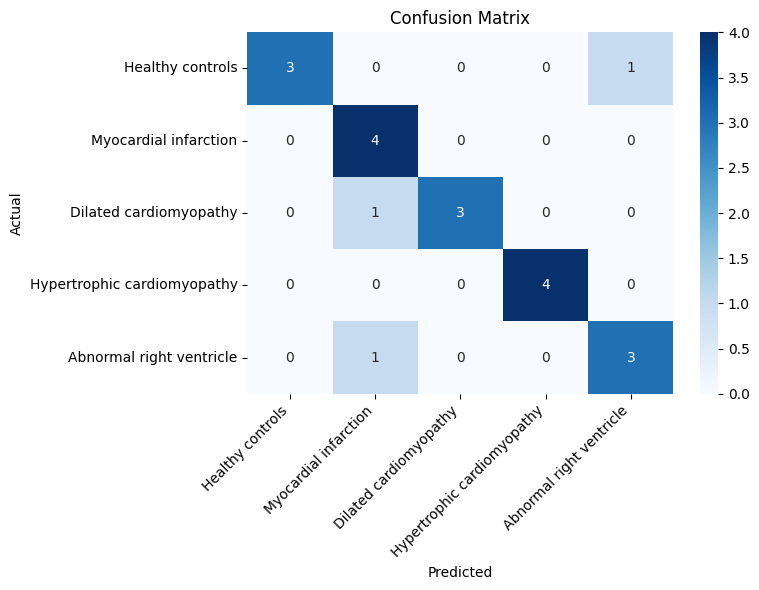

In [ ]:
plot_confusion_mat(label_test, RFF.predict(ft_test))

In [ ]:
# df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTrain.csv')  # replace with your actual file path
df = pd.read_csv(work_dir + 'data/metaDataTest.csv') 
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
nifti_test = NiftiDataset(image_path = work_dir + 'data/Test', roi=False, augment=False)

dataloader = DataLoader(nifti_test, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor = FeatureExtractor()
features_tensors = []
for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    predicted_diastole = F.one_hot((img[0,1,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    predicted_systole = F.one_hot((img[0,3,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    # print(predicted_systole.shape)
    # predicted_systole = predicted_systole(0.5)
    # predicted_systole = (predicted_systole > 0.5).astype(int)
    # predicted_diastole = (predicted_diastole > 0.5).astype(int)
    # print(predicted_systole.shape)

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        (predicted_systole[:,0]).unsqueeze(0),
        (predicted_systole[:,3]).unsqueeze(0),
        (predicted_systole[:,1]).unsqueeze(0),
        (predicted_systole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        (predicted_diastole[:,0]).unsqueeze(0),
        (predicted_diastole[:,3]).unsqueeze(0),
        (predicted_diastole[:,1]).unsqueeze(0),
        (predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_test.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )

    # plt.imshow(predicted_diastole_tensor[0,1], cmap='grey')
    # print("The feature tensor is: ", features_tensor)
    # print("The actual disease is: ", gt_disease[idx])
    features_tensors.append(features_tensor)

    # if idx==50:
    #     break


In [ ]:
df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTest.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
data_path = "./data/Test"
niftiidatasettest = NiftiDataset(image_path = data_path, roi=True, augment=False)
nifti_not_roi = NiftiDataset(image_path = data_path, roi=False, augment=False) 

dataloadertest = DataLoader(niftiidatasettest, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor_test = FeatureExtractor()
features_tensors_test = []

for idx, img in tqdm(enumerate(dataloadertest), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    diastole_image = diastole_image.to(device)
    systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    predicted_systole = (predicted_systole > 0.5)
    predicted_diastole = (predicted_diastole > 0.5)
    # print(predicted_systole.shape)
    # Get the actual mask
    img_2 = nifti_not_roi[idx].permute(3,0,1,2)
    # print(img_2.shape)
    mask_diastole = F.one_hot((img_2[:,1,:,:]*3).long(), num_classes=4).permute(0,3,1,2).numpy()
    mask_systole = F.one_hot((img_2[:,3,:,:]*3).long(), num_classes=4).permute(0,3,1,2).numpy()
    # Compute padding sizes
    pad_height = 220 - 128
    pad_width = 220 - 128

    # Padding: (left, right, top, bottom)
    # F.pad expects the last dimensions first
    padding = (pad_width // 2, pad_width - pad_width // 2,
           pad_height // 2, pad_height - pad_height // 2)
    mask_lv_sys = F.pad(predicted_systole[:,3], padding, mode='constant', value=0).numpy()
    mask_lv_dias = F.pad(predicted_diastole[:,3], padding, mode='constant', value=0).numpy()
    # print(mask_diastole.shape)
    # break

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(mask_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(mask_lv_sys).unsqueeze(0), # Left Ventricle
        torch.from_numpy(mask_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(mask_systole[:,2]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(mask_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(mask_lv_dias).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        (1,1,1)
    )
    features_tensors_test.append(features_tensor)

Creating the dataset: 0it [00:03, ?it/s]


KeyboardInterrupt: 

In [ ]:
# labels_test = grid_RF.predict(features_tensors_test)
# Best params: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
# RF=RandomForestClassifier(bootstrap = True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=200)
# RF.fit(feat_train, label_train)
features_tensors_test = normalization2.transform(features_tensors_test)
features_tensors_test = features_tensors_test[:,sorted_indices[:best_index]]
labels_test=RFF.predict(features_tensors_test)
# labels_test = RF.predict(features_tensors_test)



In [ ]:
features_tensors_test[0]

array([-1.22153537e-01, -1.17254390e-01,             nan,  3.14188759e-01,
        1.39037424e-01,  7.65684571e-01,  1.65314402e-01,  1.35604079e-01,
        2.68618169e+06,  1.43600637e+06,  1.31540777e+06,  9.77242420e+05,
        5.88235294e-01,  3.97727273e-01])

In [ ]:

labels_test = grid_RF.predict(features_tensors_test)
labels_test

array([4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2,
       4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 4, 4, 4])

In [ ]:
print(np.unique(labels_test, return_counts=True))

(array([2, 4]), array([10, 40]))


In [ ]:
grid_RF.score(feat_test,label_test)df = pd.read_csv(work_dir + 'data/metaDataTrain.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
data_path = 'data/Train'
nifti_not_roi = NiftiDataset(image_path = data_path, roi=False, augment=False) 
dataloader = DataLoader(nifti_not_roi, batch_size=1, shuffle=False, num_workers=8) #This is a batchsize of 1 because the images are 3D

feature_extractor = FeatureExtractor()
features_tensors = []

for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    # diastole_image = diastole_image.to(device)
    # systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    # predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    # predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    # predicted_systole = (predicted_systole > 0.5)
    # predicted_diastole = (predicted_diastole > 0.5)
    # print(predicted_systole.shape)
    # Get the actual mask
    # img_2 = nifti_not_roi[idx].permute(3,0,1,2)
    # print(img_2.shape)
    mask_diastole = F.one_hot((img[:,1,:,:]*3).long().squeeze(0), num_classes=4).permute(0,3,1,2).numpy()
    mask_systole = F.one_hot((img[:,3,:,:]*3).long().squeeze(0), num_classes=4).permute(0,3,1,2).numpy()
    # print(mask_diastole.shape)
    
    # Compute padding sizes
    # pad_height = 220 - 128
    # pad_width = 220 - 128

    # Padding: (left, right, top, bottom)
    # F.pad expects the last dimensions first
    # padding = (pad_width // 2, pad_width - pad_width // 2,
    #        pad_height // 2, pad_height - pad_height // 2)
    # mask_lv_sys = F.pad(predicted_systole[:,3], padding, mode='constant', value=0).numpy()
    # mask_lv_dias = F.pad(predicted_diastole[:,3], padding, mode='constant', value=0).numpy()
    # print(mask_diastole.shape)
    # break

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(mask_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(mask_systole[:,3]).unsqueeze(0), # Left Ventricle
        torch.from_numpy(mask_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(mask_systole[:,2]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(mask_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,3]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    voxel_spacing = nifti_not_roi.__get_spacing__(idx)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        voxel_spacing,
    )
    features_tensors.append(features_tensor)

# To avoid possible nan values
gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]


Creating the dataset: 12it [00:01, 14.05it/s]

Creating the dataset: 100it [00:06, 15.65it/s]


In [ ]:
len(features_tensors)
gt_disease = np.array(gt_disease)
features_tensors = np.stack(features_tensors, axis=0)


In [ ]:
# Masks order: background, right ventricle, myocardium, left ventricle
# Wanted for the feature extraction: (background, left ventricle, right ventricle, myocardium).
#(B, C, H, W)
df = pd.read_csv(work_dir + 'data/metaDataTrain.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
data_path = 'data/Train'
nifti_not_roi = NiftiDataset(image_path = data_path, roi=False, augment=False) 
dataloader = DataLoader(niftiidataset, batch_size=1, shuffle=False, num_workers=8) #This is a batchsize of 1 because the images are 3D

feature_extractor = FeatureExtractor()
features_tensors = []

for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    diastole_image = diastole_image.to(device)
    systole_image = systole_image.to(device)

    # Create the predicted masks to extract the Left Ventricle mask
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu()
    predicted_systole = model(systole_image).squeeze(0).detach().cpu()
    predicted_systole = (predicted_systole > 0.5)
    predicted_diastole = (predicted_diastole > 0.5)
    # print(predicted_systole.shape)
    # Get the actual mask
    img_2 = nifti_not_roi[idx].permute(3,0,1,2)
    # print(img_2.shape)
    mask_diastole = F.one_hot((img_2[:,1,:,:]*3).long(), num_classes=4).permute(0,3,1,2).numpy()
    mask_systole = F.one_hot((img_2[:,3,:,:]*3).long(), num_classes=4).permute(0,3,1,2).numpy()
    # Compute padding sizes
    pad_height = 220 - 128
    pad_width = 220 - 128

    # Padding: (left, right, top, bottom)
    # F.pad expects the last dimensions first
    padding = (pad_width // 2, pad_width - pad_width // 2,
           pad_height // 2, pad_height - pad_height // 2)
    mask_lv_sys = F.pad(predicted_systole[:,3], padding, mode='constant', value=0).numpy()
    mask_lv_dias = F.pad(predicted_diastole[:,3], padding, mode='constant', value=0).numpy()
    # print(mask_diastole.shape)
    # break

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(mask_systole[:,0]).unsqueeze(0), # Background
        torch.from_numpy(mask_lv_sys).unsqueeze(0), # Left Ventricle
        torch.from_numpy(mask_systole[:,1]).unsqueeze(0), # Right Ventricle
        torch.from_numpy(mask_systole[:,2]).unsqueeze(0), # Myocardium
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(mask_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(mask_lv_dias).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(mask_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
        (1,1,1)
    )
    features_tensors.append(features_tensor)

gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]



Creating the dataset: 0it [00:02, ?it/s]


KeyboardInterrupt: 

(8, 220, 220)


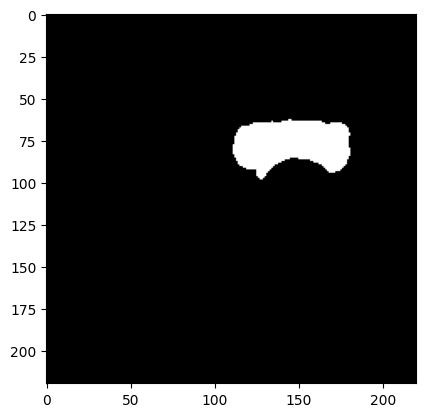

In [ ]:
print(mask_diastole[:,3].shape)
plt.imshow(mask_diastole[3,1],cmap='grey')

TRY WITH THE GROUND TRUTH IN THIS CASE TO SE IF IT WORKS.

In [ ]:
len(features_tensors[0])

27

In [ ]:
import csv

# Open a new CSV file
with open('numbers.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    writer.writerow(['Id', 'Category'])
    
    # Write index and value
    for idx, num in enumerate(labels_test):
        writer.writerow([idx+101, num])


In [ ]:
feature_list = []
labels_list = []
for idx in tqdm(range(len(niftiidataset)), desc="Creating the dataset"):
    print(idx)
    img = niftiidataset[idx].numpy()
    print(idx)
    # img = niftiidataset[idx].numpy()
    # Extract masks
    mask_diastole = img[1,:,:,:] * 3
    mask_systole = img[3,:,:,:] * 3
    mask_diastole=mask_diastole
    mask_systole=mask_systole
    # plt.imshow(mask_diastole[:,:,3])
    # plt.show()
    # print(mask_diastole.shape)
    
    # path_to_image = os.path.join(data_path, image_list[idx])
    # mask_diastole = nib.load(os.path.join(path_to_image, f"{image_list[idx]}_ED_seg.nii")).get_fdata()
    # plt.imshow(mask_diastole[:,:,3])
    # plt.show()
    # mask_systole = nib.load(os.path.join(path_to_image, f"{image_list[idx]}_ES_seg.nii")).get_fdata()
    # break
    

    mask_lr_ed = (mask_diastole == 1)
    mask_myo_ed = (mask_diastole == 2)
    mask_lv_ed = (mask_diastole == 3)

    mask_lr_es = (mask_systole == 1)
    mask_myo_es = (mask_systole == 2)
    mask_lv_es = (mask_systole == 3)

    # Volumes
    vol_lv_ed = np.sum(mask_lv_ed)
    vol_lr_ed = np.sum(mask_lr_ed)
    vol_myo_ed = np.sum(mask_myo_ed)
    vol_lv_es = np.sum(mask_lv_es)
    vol_lr_es = np.sum(mask_lr_es)
    vol_myo_es = np.sum(mask_myo_es)

    # Ratios
    ratio_myo_lv_ed = vol_myo_ed / (vol_lv_ed + 1e-6)
    ratio_myo_lv_es = vol_myo_es / (vol_lv_es + 1e-6)

    ratio_lv_lr_ed = vol_lv_ed / (vol_lr_ed + 1e-6)
    ratio_lv_lr_es = vol_lv_es / (vol_lr_es + 1e-6)

    # Ejection Fractions
    ejec_frac_lv = (vol_lv_ed - vol_lv_es) / (vol_lv_ed + 1e-6)
    ejec_frac_lr = (vol_lr_ed - vol_lr_es) / (vol_lr_ed + 1e-6)

    # Volume Differences
    delta_vol_lv = vol_lv_ed - vol_lv_es
    delta_vol_myo = vol_myo_ed - vol_myo_es
    delta_vol_lr = vol_lr_ed - vol_lr_es

    # Volume Ratios ES/ED
    ratio_lv_es_ed = vol_lv_es / (vol_lv_ed + 1e-6)
    ratio_lr_es_ed = vol_lr_es / (vol_lr_ed + 1e-6)
    ratio_myo_es_ed = vol_myo_es / (vol_myo_ed + 1e-6)

    # Surface Areas (approximate using Marching Cubes)
    try:
        surface_lv_ed = compute_surface(mask_lv_ed)
        surface_lv_es = compute_surface(mask_lv_es)
    except:
        surface_lv_ed = 1e-6  # prevent division by zero if surface computation fails
        surface_lv_es = 1e-6

    # Compactness
    compactness_lv_ed = (vol_lv_ed ** (2/3)) / (surface_lv_ed + 1e-6)
    compactness_lv_es = (vol_lv_es ** (2/3)) / (surface_lv_es + 1e-6)

    # Myocardial Thickness Approximation
    thickness_myo_ed = vol_myo_ed / (surface_lv_ed + 1e-6)
    thickness_myo_es = vol_myo_es / (surface_lv_es + 1e-6)

    # Clinical Features: BSA (DuBois formula)
    height = Heights[idx]  # in cm
    weight = Weights[idx]  # in kg
    bsa = 0.007184 * (height**0.725) * (weight**0.425)

    # Indexed volumes
    vol_lv_ed_indexed = vol_lv_ed / (bsa + 1e-6)
    vol_lv_es_indexed = vol_lv_es / (bsa + 1e-6)

    # Final feature vector
    features = [
        vol_lv_ed, 
        vol_lr_ed, 
        vol_myo_ed,
        vol_lv_es,
        vol_lr_es,
        vol_myo_es,
        ejec_frac_lv,
        ejec_frac_lr,
        ratio_lv_lr_ed,
        ratio_lv_lr_es,
        ratio_myo_lv_ed,
        ratio_myo_lv_es,
        delta_vol_lv,
        delta_vol_myo,
        delta_vol_lr,
        ratio_lv_es_ed,
        ratio_lr_es_ed,
        ratio_myo_es_ed,
        compactness_lv_ed,
        compactness_lv_es,
        thickness_myo_ed,
        thickness_myo_es,
        vol_lv_ed_indexed,
        vol_lv_es_indexed,
        height,
        weight,
        bsa
    ]

    feature_numpy = np.array(features)
    features_list.append(feature_numpy)
    labels_list.append(gt_disease[idx])

#%%
gt_disease = [x for idx, x in enumerate(gt_disease) if features_list[idx][0]>1]
features_list = [x for x in features_list if x[0]>1]
features_list = np.stack(features_list, axis=0)
print((features_list))
labels_list = np.array(labels_list)
print(type(labels_list))
print(labels_list)
#%%
print(features_list.shape)
print(type(features_list))
print((features_list[0]))
#%%

# features_tensors = np.array(features_tensors)
# gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]<1]
feat_train, feat_test, label_train, label_test = train_test_split(
    features_list, 
    labels_list, 
    stratify=labels_list,
    test_size=0.2, 
    random_state=42,
)

# feat_train = features_list
# label_train = labels_list
#%%
print(feat_train[0])

#%% Normalize the data
normalization = MinMaxScaler()
normalization.fit(feat_train)
feat_train = normalization.transform(feat_train)
feat_test = normalization.transform(feat_test)
print(np.unique(label_test))
print(np.unique(label_train))
#%%
print(feat_train[0])
#%%
print("Start")
RF=RandomForestClassifier(class_weight='balanced')
# p_grid_RF = {'n_estimators': [50,100,150], 'max_depth': [2,3,4,5], "bootstrap": [True, False]}
# p_grid_RF = {'n_estimators':[50,100,150,200,250,300,350,400]}

p_grid_RF = {
    'n_estimators': [100, 200],
    'max_depth': [3,5],  # More flexibility in tree depth
    'min_samples_split': [2, 10],
    'min_samples_leaf': [10, 15],
    'bootstrap': [True, False]
}


grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=10, verbose=1)
grid_RF.fit(feat_train, label_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(feat_test, label_test))
print("Score in train: ", grid_RF.score(feat_train, label_train))

#%%

Creating the dataset:   0%|          | 0/100 [00:00<?, ?it/s]

0


Creating the dataset:   0%|          | 0/100 [00:19<?, ?it/s]

0


NameError: name 'features_list' is not defined